In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Task 1 (3 points)

Consider the following toy dataset:

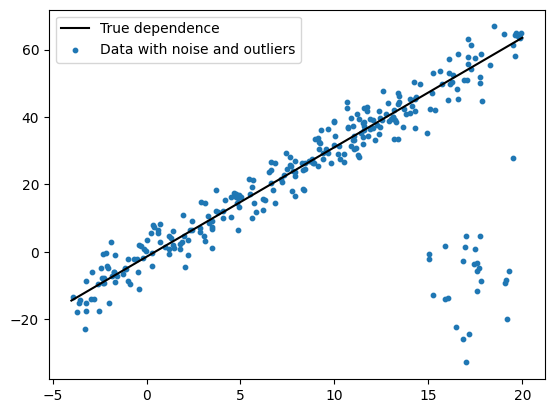

In [3]:
true_function = lambda x: 3.25 * x - 1.47
noise_function = lambda x: (
    np.random.normal(size=len(x)) * 4. +
    np.where(
        x < 15,
        0.,
        -60 + np.random.normal(size=len(x)) * 10
    ) * (np.random.uniform(size=len(x)) < 0.4).astype(int)
)
limits = (-4., 20.)

def generate_dataset(N=300):
  x = np.random.uniform(*limits, size=N)
  y = true_function(x) + noise_function(x)

  return x[:,None], y

X, y = generate_dataset()

x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend();

Implement a linear model $\hat y(x|w) = w_1\cdot x + w_0$ with MAE loss:
$$\text{MAE}(w) = \frac{1}{N}\sum_{i=1}^N\left|y_i - \hat y(x_i|w)\right|,$$
using gradient descent optimization in `numpy`.

*Hint: introduce a constant feature to account for the bias term to make the formulas simpler.*

Plot the learning curve and the final fit. Also, fit the same data with `sklearn`'s `LinearRegression`, and compare the two fits on the same plot. What do you observe? Write a short comment.

Epoch 0, Loss: 32.9242
Epoch 100, Loss: 7.6712
Epoch 200, Loss: 7.6468
Epoch 300, Loss: 7.6245
Epoch 400, Loss: 7.6035
Epoch 500, Loss: 7.5840
Epoch 600, Loss: 7.5651
Epoch 700, Loss: 7.5512
Epoch 800, Loss: 7.5392
Epoch 900, Loss: 7.5297

Custom MAE Model - Final weights: w0=-0.4853, w1=3.1037
Custom MAE Model - Final MAE: 7.5238
Sklearn MSE Model - Final MAE: 9.7227


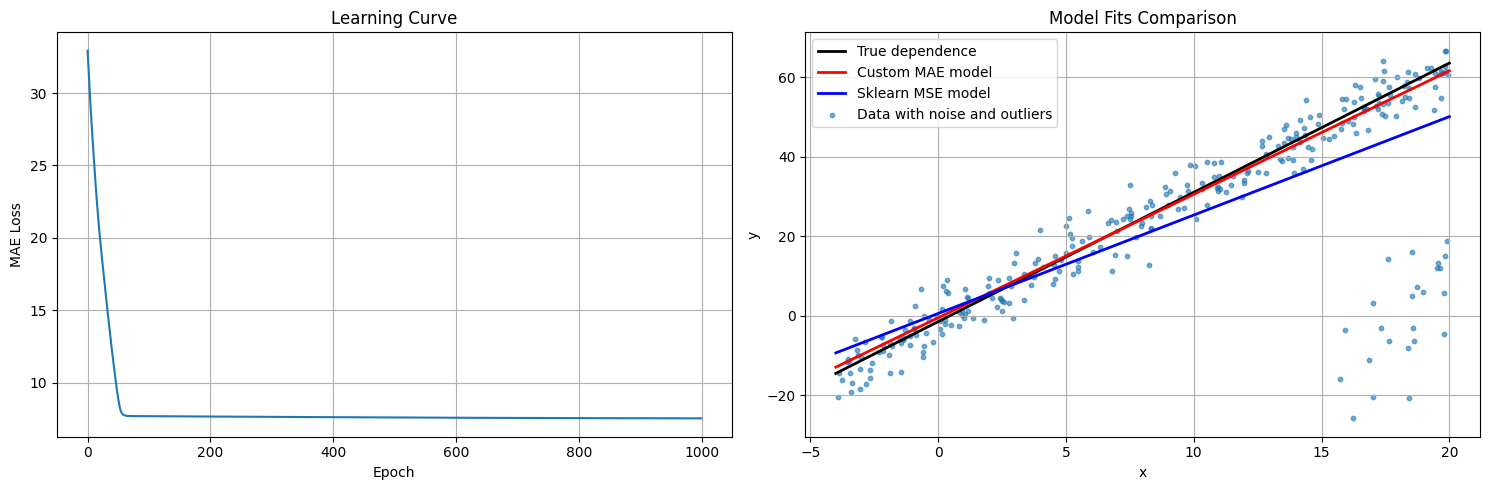

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

true_function = lambda x: 3.25 * x - 1.47
noise_function = lambda x: (
    np.random.normal(size=len(x)) * 4. +
    np.where(
        x < 15,
        0.,
        -60 + np.random.normal(size=len(x)) * 10
    ) * (np.random.uniform(size=len(x)) < 0.4).astype(int)
)
limits = (-4., 20.)

def generate_dataset(N=300):
    x = np.random.uniform(*limits, size=N)
    y = true_function(x) + noise_function(x)
    return x[:, None], y

X, y = generate_dataset()

X_with_bias = np.hstack([np.ones((X.shape[0], 1)), X])

w = np.random.randn(2)  # [w0, w1]

learning_rate = 0.01
epochs = 1000
losses = []

for epoch in range(epochs):
    y_pred = X_with_bias @ w

    loss = np.mean(np.abs(y - y_pred))
    losses.append(loss)

    errors = y - y_pred
    grad_w0 = -np.mean(np.sign(errors))  # For bias term (x0 = 1)
    grad_w1 = -np.mean(np.sign(errors) * X.flatten())  # For x term

    w[0] -= learning_rate * grad_w0
    w[1] -= learning_rate * grad_w1

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

sklearn_model = LinearRegression()
sklearn_model.fit(X, y)
sklearn_y_pred = sklearn_model.predict(X)
sklearn_loss = mean_absolute_error(y, sklearn_y_pred)

print(f"\nCustom MAE Model - Final weights: w0={w[0]:.4f}, w1={w[1]:.4f}")
print(f"Custom MAE Model - Final MAE: {losses[-1]:.4f}")
print(f"Sklearn MSE Model - Final MAE: {sklearn_loss:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(losses)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MAE Loss')
ax1.set_title('Learning Curve')
ax1.grid(True)

x_plot = np.linspace(*limits, 101)
x_plot_with_bias = np.hstack([np.ones((101, 1)), x_plot[:, None]])

ax2.plot(x_plot, true_function(x_plot), c='black', label='True dependence', linewidth=2)

custom_y_pred_plot = x_plot_with_bias @ w
ax2.plot(x_plot, custom_y_pred_plot, c='red', label='Custom MAE model', linewidth=2)

sklearn_y_pred_plot = sklearn_model.predict(x_plot[:, None])
ax2.plot(x_plot, sklearn_y_pred_plot, c='blue', label='Sklearn MSE model', linewidth=2)

ax2.scatter(X, y, s=10, alpha=0.6, label='Data with noise and outliers')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Model Fits Comparison')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

**Observations:**

The custom MAE model converges quickly and provides a fit that is closer to the true dependence compared to the sklearn MSE model. Since MAE penalizes errors linearly, it is more robust to noise and outliers, which explains why its line aligns better with the true function. The MSE model, on the other hand, is strongly influenced by large outliers, causing its fitted line to deviate more from the true dependence. This highlights the advantage of MAE when dealing with datasets that contain outliers.

## Task 2 (2 + 1 points)

* Wrap your solution from the previous task into a class. Plot the learning curve and the final fit. Compare and comment your results with the previos ones. **(2 points)**

* Make it possible to choose a loss function. **(1 point)**

In [7]:
from sklearn.base import BaseEstimator, RegressorMixin

In [10]:
class LinearRegressionSGD(BaseEstimator, RegressorMixin):
    def __init__(self, loss_function='mae', learning_rate=0.01, epochs=1000, random_state=None, delta=1.0):
        self.loss_function = loss_function
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.delta = delta
        self.w = None
        self.losses = []

    def _add_bias(self, X):
        """Add bias term to features"""
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def _mae_loss(self, y_true, y_pred):
        """Mean Absolute Error loss"""
        return np.mean(np.abs(y_true - y_pred))

    def _mae_gradient(self, X, y_true, y_pred):
        """Gradient for MAE loss"""
        errors = y_true - y_pred
        grad = -np.sign(errors)
        gradient = np.zeros(X.shape[1])
        for j in range(X.shape[1]):
            gradient[j] = np.mean(grad * X[:, j])
        return gradient

    def _mse_loss(self, y_true, y_pred):
        """Mean Squared Error loss"""
        return np.mean((y_true - y_pred) ** 2)

    def _mse_gradient(self, X, y_true, y_pred):
        """Gradient for MSE loss"""
        errors = y_true - y_pred
        gradient = np.zeros(X.shape[1])
        for j in range(X.shape[1]):
            gradient[j] = -2 * np.mean(errors * X[:, j])
        return gradient

    def _huber_loss(self, y_true, y_pred):
        """Huber loss - combination of MSE and MAE"""
        errors = np.abs(y_true - y_pred)
        condition = errors <= self.delta
        quadratic = np.where(condition, 0.5 * errors ** 2, self.delta * errors - 0.5 * self.delta ** 2)
        return np.mean(quadratic)

    def _huber_gradient(self, X, y_true, y_pred):
        """Gradient for Huber loss"""
        errors = y_true - y_pred
        condition = np.abs(errors) <= self.delta
        grad = np.where(condition, errors, self.delta * np.sign(errors))
        gradient = np.zeros(X.shape[1])
        for j in range(X.shape[1]):
            gradient[j] = -np.mean(grad * X[:, j])
        return gradient

    def fit(self, x, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        X_with_bias = self._add_bias(x)

        self.w = np.random.randn(X_with_bias.shape[1])
        self.losses = []

        for epoch in range(self.epochs):
            y_pred = X_with_bias @ self.w

            # Calculate loss and gradient based on chosen loss function
            if self.loss_function == 'mae':
                loss = self._mae_loss(y, y_pred)
                grad = self._mae_gradient(X_with_bias, y, y_pred)
            elif self.loss_function == 'mse':
                loss = self._mse_loss(y, y_pred)
                grad = self._mse_gradient(X_with_bias, y, y_pred)
            elif self.loss_function == 'huber':
                loss = self._huber_loss(y, y_pred)
                grad = self._huber_gradient(X_with_bias, y, y_pred)
            else:
                raise ValueError("Unsupported loss function. Choose 'mae', 'mse', or 'huber'")

            self.losses.append(loss)

            self.w -= self.learning_rate * grad

            # Early stopping if loss doesn't improve much
            if epoch > 10 and abs(self.losses[-1] - self.losses[-2]) < 1e-6:
                break

        return self

    def predict(self, x):
        if self.w is None:
            raise ValueError("Model not fitted yet. Call fit() first.")

        X_with_bias = self._add_bias(x)
        return X_with_bias @ self.w

    def fit_predict(self, x, y):
        self.fit(x, y)
        return self.predict(x)

MAE - Final loss: 7.0542, Weights: w0=-0.6675, w1=3.1247
MSE - Final loss: 171968252065410081810038429021945322750779731551136558747574449730435087677009331504297970723451679752227260056551349529282438787377845216565274241130387380955724757037166815944376320.0000, Weights: w0=-107902817754405304034047236624559709573158391913902641592079721541112534614772681097084928.0000, w1=-1523357184387426473190335012645664171125126556941262661569222011372477367888199966076698624.0000
HUBER - Final loss: 6.5800, Weights: w0=-0.6808, w1=3.1200


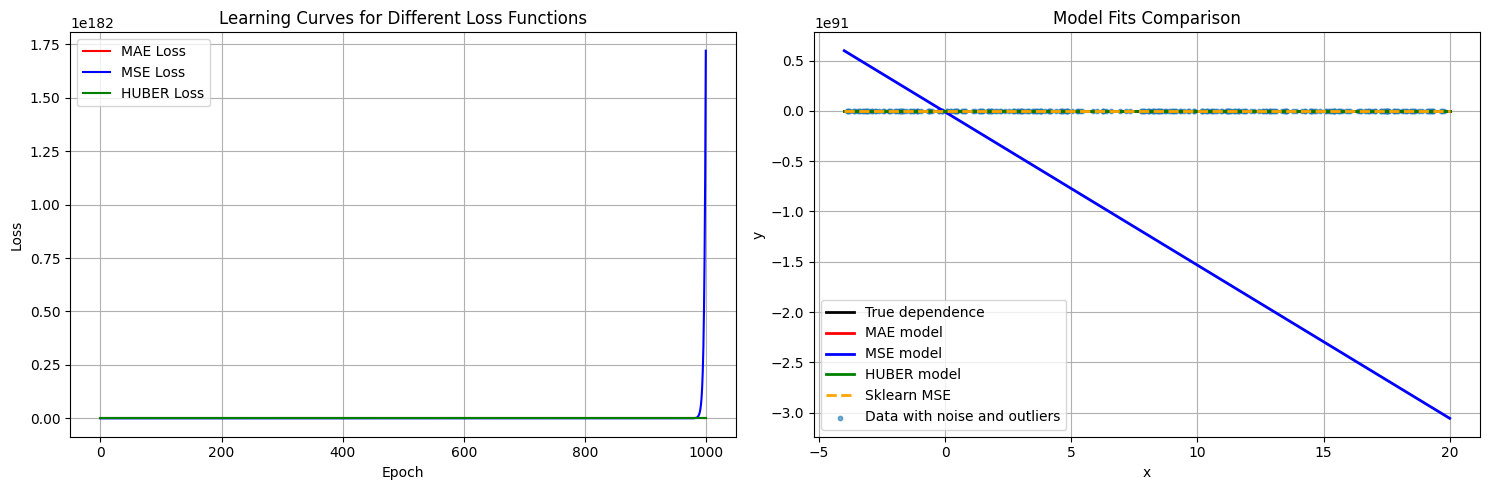


Sklearn LinearRegression - Weights: w0=-0.1626, w1=2.5541
Sklearn LinearRegression - MAE: 8.8534


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

true_function = lambda x: 3.25 * x - 1.47
noise_function = lambda x: (
    np.random.normal(size=len(x)) * 4. +
    np.where(
        x < 15,
        0.,
        -60 + np.random.normal(size=len(x)) * 10
    ) * (np.random.uniform(size=len(x)) < 0.4).astype(int)
)
limits = (-4., 20.)

def generate_dataset(N=300):
    x = np.random.uniform(*limits, size=N)
    y = true_function(x) + noise_function(x)
    return x[:, None], y

X, y = generate_dataset()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

loss_functions = ['mae', 'mse', 'huber']
colors = ['red', 'blue', 'green']

# Plot 1: Learning curves
for loss_func, color in zip(loss_functions, colors):
    model = LinearRegressionSGD(loss_function=loss_func, learning_rate=0.01, epochs=1000, random_state=42)
    model.fit(X, y)
    ax1.plot(model.losses, color=color, label=f'{loss_func.upper()} Loss')
    print(f"{loss_func.upper()} - Final loss: {model.losses[-1]:.4f}, Weights: w0={model.w[0]:.4f}, w1={model.w[1]:.4f}")

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Learning Curves for Different Loss Functions')
ax1.legend()
ax1.grid(True)

# Plot 2: Model fits comparison
x_plot = np.linspace(*limits, 101)
x_plot_2d = x_plot[:, None]

ax2.plot(x_plot, true_function(x_plot), c='black', label='True dependence', linewidth=2)

for loss_func, color in zip(loss_functions, colors):
    model = LinearRegressionSGD(loss_function=loss_func, learning_rate=0.01, epochs=1000, random_state=42)
    model.fit(X, y)
    y_pred_plot = model.predict(x_plot_2d)
    ax2.plot(x_plot, y_pred_plot, color=color, label=f'{loss_func.upper()} model', linewidth=2)

sklearn_model = LinearRegression()
sklearn_model.fit(X, y)
sklearn_y_pred = sklearn_model.predict(x_plot_2d)
ax2.plot(x_plot, sklearn_y_pred, color='orange', linestyle='--', label='Sklearn MSE', linewidth=2)

ax2.scatter(X, y, s=10, alpha=0.6, label='Data with noise and outliers')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Model Fits Comparison')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\nSklearn LinearRegression - Weights: w0={sklearn_model.intercept_:.4f}, w1={sklearn_model.coef_[0]:.4f}")
print(f"Sklearn LinearRegression - MAE: {mean_absolute_error(y, sklearn_model.predict(X)):.4f}")

**Observations:**

Wrapping the solution into a class made it easier to switch between loss functions. The MAE and Huber losses converged stably and gave fits close to the true function, showing robustness to outliers. The MSE implementation diverged under gradient descent due to sensitivity to large errors and instability at the chosen learning rate. Compared to the previous task, adding Huber loss provides a good compromise between MAE and MSE, while the sklearn MSE model remains stable since it does not rely on iterative optimization.